In [1]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [2]:
import tensorflow as tf

# GPU 사용 설정
device_name = tf.test.gpu_device_name()
if not tf.config.list_physical_devices('GPU'):
    print("GPU를 찾을 수 없습니다. 런타임 유형을 GPU로 변경해주세요.")
else:
    print(f"GPU 장치: {device_name}")

GPU를 찾을 수 없습니다. 런타임 유형을 GPU로 변경해주세요.


In [7]:
import pandas as pd
import numpy as np
import os
os.chdir('/content/drive/MyDrive/젠트리피케이션/data/')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import math
import openpyxl
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

# 1) 데이터 수집 및 전처리

## 1.1) row data 전처리

### 소매점, 음식점

In [4]:
path = '/content/drive/MyDrive/젠트리피케이션/raw data/'

In [5]:
lst_food = ['분식전문점', '치킨전문점', '패스트푸드점', '제과점', '양식음식점', '일식음식점', '중식음식점', '한식음식점', '호프-간이주점', '커피-음료']
lst_re = ['전자상거래업', '주유소', '예술품', '자동차부품', '조명용품', '철물점', '가전제품',
          '가구', '화초', '섬유제품', '완구', '운동/경기용품', '미용재료', '화장품', '문구', '서적',
          '의료기기', '의약품', '시계및귀금속', '안경', '가방', '신발', '유아의류', '일반의류',
          '육류판매', '미곡판매', '주류도매', '컴퓨터및주변장치판매', '편의점', '슈퍼마켓',
          '재생용품 판매점', '중고차판매', '악기', '애완동물', '자전거 및 기타운송장비',
          '수산물판매', '가정용품임대', '모터사이클및부품', '한복점','중고가구', '인테리어', '핸드폰', '청과상', '반찬가게']

In [6]:
data = pd.read_csv('/content/drive/MyDrive/젠트리피케이션/raw data/상권-점포_total.csv')
data['개폐업_점포_수'] = data['개업_점포_수'] + data['폐업_점포_수']

In [8]:
data.head()
data.shape

,기준_년_코드,기준_분기_코드,상권_코드_명,상권_코드,상권_구분_코드,상권_구분_코드_명,서비스_업종_코드,서비스_업종_코드_명,점포_수,유사_업종_점포_수,개업_율,개업_점포_수,폐업_률,폐업_점포_수,프랜차이즈_점포_수,개폐업_점포_수
0,2017,1,배화여자대학교(박노수미술관),3110008,A,골목상권,CS100001,한식음식점,17,17,6,1,0,0,0,1
1,2017,1,배화여자대학교(박노수미술관),3110008,A,골목상권,CS100002,중식음식점,2,2,0,0,0,0,0,0
2,2017,1,배화여자대학교(박노수미술관),3110008,A,골목상권,CS100003,일식음식점,2,2,0,0,0,0,0,0
3,2017,1,배화여자대학교(박노수미술관),3110008,A,골목상권,CS100004,양식음식점,18,18,11,2,6,1,0,3
4,2017,1,배화여자대학교(박노수미술관),3110008,A,골목상권,CS100005,제과점,8,10,10,1,0,0,2,1


(1859643, 16)

In [9]:
data['기준_년_코드'].value_counts()

기준_년_코드
2022    298905
2020    298475
2021    298401
2019    296051
2018    295941
2017    295681
2023     76189
Name: count, dtype: int64

In [10]:
data[data['기준_년_코드']==2023]['상권_코드_명'].nunique()

1648

In [11]:
df_stor = data[['기준_년_코드', '기준_분기_코드', '상권_코드_명', '서비스_업종_코드_명', '유사_업종_점포_수']]
df_stor.head(3)

,기준_년_코드,기준_분기_코드,상권_코드_명,서비스_업종_코드_명,유사_업종_점포_수
0,2017,1,배화여자대학교(박노수미술관),한식음식점,17
1,2017,1,배화여자대학교(박노수미술관),중식음식점,2
2,2017,1,배화여자대학교(박노수미술관),일식음식점,2


In [12]:
lst_col = ['총_점포_수', '개업_점포_비율', '폐업_점포_비율', '개폐업_점포_비율', '프랜차이즈_점포_비율']

In [13]:
df = data[data['서비스_업종_코드_명'].isin(lst_food)]
df = df.groupby(['기준_년_코드', '기준_분기_코드', '상권_코드_명']).agg({'유사_업종_점포_수':'sum', '개업_점포_수':'sum', '폐업_점포_수':'sum', '개폐업_점포_수':'sum',
                                                         '프랜차이즈_점포_수':'sum'}).reset_index()
df['개업_점포_비율'] = df['개업_점포_수'] / df['유사_업종_점포_수']
df['폐업_점포_비율'] = df['폐업_점포_수'] / df['유사_업종_점포_수']
df['개폐업_점포_비율'] = (df['개업_점포_수'] + df['폐업_점포_수']) / df['유사_업종_점포_수']
df['프랜차이즈_점포_비율'] = df['프랜차이즈_점포_수'] / df['유사_업종_점포_수']
df = df.rename(columns={'유사_업종_점포_수':'총_점포_수'})

#df = df.drop(['개업_점포_수', '폐업_점포_수', '프랜차이즈_점포_수', '개폐업_점포_수'], axis=1)

for col in df.iloc[:, 3:].columns:
  new_col = '음식점_' + col
  df = df.rename(columns={col:new_col})

df_음식점 = df.copy()

In [14]:
df = data[data['서비스_업종_코드_명'].isin(lst_re)]
df = df.groupby(['기준_년_코드', '기준_분기_코드', '상권_코드_명']).agg({'유사_업종_점포_수':'sum', '개업_점포_수':'sum', '폐업_점포_수':'sum', '개폐업_점포_수':'sum',
                                                         '프랜차이즈_점포_수':'sum'}).reset_index()
df['개업_점포_비율'] = df['개업_점포_수'] / df['유사_업종_점포_수']
df['폐업_점포_비율'] = df['폐업_점포_수'] / df['유사_업종_점포_수']
df['개폐업_점포_비율'] = (df['개업_점포_수'] + df['폐업_점포_수']) / df['유사_업종_점포_수']
df['프랜차이즈_점포_비율'] = df['프랜차이즈_점포_수'] / df['유사_업종_점포_수']
df = df.rename(columns={'유사_업종_점포_수':'총_점포_수'})


#df = df.drop(['개업_점포_수', '폐업_점포_수', '프랜차이즈_점포_수', '개폐업_점포_수'], axis=1)

for col in  df.iloc[:, 3:].columns:
  new_col = '소매점_' + col
  df = df.rename(columns={col:new_col})

df_소매점 = df.copy()

In [15]:
df = data.copy()
df = df.groupby(['기준_년_코드', '기준_분기_코드', '상권_코드_명']).agg({'유사_업종_점포_수':'sum', '개업_점포_수':'sum', '폐업_점포_수':'sum', '개폐업_점포_수':'sum',
                                                         '프랜차이즈_점포_수':'sum'}).reset_index()
df['개업_점포_비율'] = df['개업_점포_수'] / df['유사_업종_점포_수']
df['폐업_점포_비율'] = df['폐업_점포_수'] / df['유사_업종_점포_수']
df['개폐업_점포_비율'] = (df['개업_점포_수'] + df['폐업_점포_수']) / df['유사_업종_점포_수']
df['프랜차이즈_점포_비율'] = df['프랜차이즈_점포_수'] / df['유사_업종_점포_수']
df = df.rename(columns={'유사_업종_점포_수':'총_점포_수'})


#df = df.drop(['개업_점포_수', '폐업_점포_수', '프랜차이즈_점포_수', '개폐업_점포_수'], axis=1)

df_total = df.copy()

In [17]:
df_음식점.head()
df_음식점.shape

,기준_년_코드,기준_분기_코드,상권_코드_명,음식점_총_점포_수,음식점_개업_점포_수,음식점_폐업_점포_수,음식점_개폐업_점포_수,음식점_프랜차이즈_점포_수,음식점_개업_점포_비율,음식점_폐업_점포_비율,음식점_개폐업_점포_비율,음식점_프랜차이즈_점포_비율
0,2017,1,4.19민주묘지역 2번,51,0,2,2,11,0.000000,0.039216,0.039216,0.215686
1,2017,1,63빌딩,43,0,1,1,7,0.000000,0.023256,0.023256,0.162791
2,2017,1,DMC(디지털미디어시티),363,26,23,49,106,0.071625,0.063361,0.134986,0.292011
3,2017,1,GS강동자이아파트,44,2,3,5,9,0.045455,0.068182,0.113636,0.204545
4,2017,1,G타워,31,5,1,6,10,0.161290,0.032258,0.193548,0.322581


(40892, 12)

In [18]:
df_소매점.head()
df_소매점.shape

,기준_년_코드,기준_분기_코드,상권_코드_명,소매점_총_점포_수,소매점_개업_점포_수,소매점_폐업_점포_수,소매점_개폐업_점포_수,소매점_프랜차이즈_점포_수,소매점_개업_점포_비율,소매점_폐업_점포_비율,소매점_개폐업_점포_비율,소매점_프랜차이즈_점포_비율
0,2017,1,4.19민주묘지역 2번,21,3,5,8,2,0.142857,0.238095,0.380952,0.095238
1,2017,1,63빌딩,86,2,6,8,1,0.023256,0.069767,0.093023,0.011628
2,2017,1,DMC(디지털미디어시티),159,6,7,13,22,0.037736,0.044025,0.081761,0.138365
3,2017,1,GS강동자이아파트,60,2,1,3,3,0.033333,0.016667,0.050000,0.050000
4,2017,1,G타워,47,2,3,5,8,0.042553,0.063830,0.106383,0.170213


(41235, 12)

In [19]:
df_total.head()
df_total.shape

,기준_년_코드,기준_분기_코드,상권_코드_명,총_점포_수,개업_점포_수,폐업_점포_수,개폐업_점포_수,프랜차이즈_점포_수,개업_점포_비율,폐업_점포_비율,개폐업_점포_비율,프랜차이즈_점포_비율
0,2017,1,4.19민주묘지역 2번,83,3,8,11,13,0.036145,0.096386,0.132530,0.156627
1,2017,1,63빌딩,181,5,7,12,10,0.027624,0.038674,0.066298,0.055249
2,2017,1,DMC(디지털미디어시티),670,43,33,76,135,0.064179,0.049254,0.113433,0.201493
3,2017,1,GS강동자이아파트,186,7,7,14,20,0.037634,0.037634,0.075269,0.107527
4,2017,1,G타워,121,12,4,16,18,0.099174,0.033058,0.132231,0.148760


(41235, 12)

In [20]:
df_mer = pd.merge(df_total, df_음식점, on=['기준_년_코드', '기준_분기_코드', '상권_코드_명'], how='left')
df_mer = pd.merge(df_mer, df_소매점, on=['기준_년_코드', '기준_분기_코드', '상권_코드_명'], how='left')

In [24]:
df_mer.to_csv(path + '상권-점포_pre.csv', index=False)

### 매출액

In [22]:
with tf.device(device_name):
  data = pd.read_csv(path + '상권-매출_total.csv')
  #data['점포수'] = data['점포수'].astype('int')

In [23]:
df_total = pd.merge(data, df_stor, on=['기준_년_코드', '기준_분기_코드', '상권_코드_명', '서비스_업종_코드_명'], how='left')
df_total.loc[(df_total['점포수']=='*') & (df_total['유사_업종_점포_수']==df_total['유사_업종_점포_수']), '점포수'] = df_total['유사_업종_점포_수']
df_total['점포수'] = df_total['점포수'].replace('*', 1.5)
df_total['점포수'] = df_total['점포수'].astype('float')
df_total = df_total.rename(columns={'점포수':'점포_수'})
df_total.head()
df_total.shape

,기준_년_코드,기준_분기_코드,상권_코드_명,상권_코드,상권_구분_코드,상권_구분_코드_명,서비스_업종_코드,서비스_업종_코드_명,분기당_매출_금액,분기당_매출_건수,...,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포_수,유사_업종_점포_수
0,2017.0,1.0,배화여자대학교(박노수미술관),3110008,A,골목상권,CS100001,한식음식점,6.447994e+08,29121.0,...,11749.0,12941.0,350.0,6443.0,6337.0,5822.0,4066.0,1680.0,38.0,17.0
1,2017.0,1.0,배화여자대학교(박노수미술관),3110008,A,골목상권,CS100002,중식음식점,5.425115e+07,2965.0,...,1576.0,819.0,71.0,586.0,526.0,674.0,346.0,195.0,3.0,2.0
2,2017.0,1.0,배화여자대학교(박노수미술관),3110008,A,골목상권,CS100003,일식음식점,6.997765e+07,4503.0,...,1999.0,2444.0,22.0,1620.0,1352.0,860.0,502.0,87.0,6.0,2.0
3,2017.0,1.0,배화여자대학교(박노수미술관),3110008,A,골목상권,CS100004,양식음식점,1.166099e+09,27937.0,...,9281.0,15488.0,250.0,8338.0,7503.0,4649.0,3003.0,1025.0,39.0,18.0
4,2017.0,1.0,배화여자대학교(박노수미술관),3110008,A,골목상권,CS100005,제과점,1.474806e+08,16597.0,...,5345.0,10776.0,477.0,4483.0,4647.0,3980.0,1888.0,648.0,15.0,10.0


(957889, 81)

In [25]:
df = df_total.copy()
df = df.groupby(['기준_년_코드', '기준_분기_코드', '상권_코드_명']).agg({'점포_수':'sum', '분기당_매출_금액':'sum', '분기당_매출_건수':'sum',
                                                    '연령대_20_매출_금액':'sum', '연령대_30_매출_금액':'sum',
                                                    '연령대_40_매출_금액':'sum'}).reset_index()
df['점포당_평균_매출_금액'] = df['분기당_매출_금액'] / df['점포_수']
df['젊은층_매출_금액'] = df['연령대_20_매출_금액'] + df['연령대_30_매출_금액']
df['젊은층_40포함_매출_금액'] = df['연령대_20_매출_금액'] + df['연령대_30_매출_금액'] + df['연령대_40_매출_금액']
df['젊은층_매출_비율'] = df['젊은층_매출_금액'] / df['분기당_매출_금액']
df['젊은층_40포함_매출_비율'] = df['젊은층_40포함_매출_금액'] / df['분기당_매출_금액']

df = df.drop(['연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액'], axis=1)
df_all = df.copy()

In [26]:
df = df_total[df_total['서비스_업종_코드_명'].isin(lst_food)]
df = df.groupby(['기준_년_코드', '기준_분기_코드', '상권_코드_명']).agg({'점포_수':'sum', '분기당_매출_금액':'sum', '분기당_매출_건수':'sum',
                                                    '연령대_20_매출_금액':'sum', '연령대_30_매출_금액':'sum',
                                                    '연령대_40_매출_금액':'sum'}).reset_index()
df['점포당_평균_매출_금액'] = df['분기당_매출_금액'] / df['점포_수']
df['젊은층_매출_금액'] = df['연령대_20_매출_금액'] + df['연령대_30_매출_금액']
df['젊은층_40포함_매출_금액'] = df['연령대_20_매출_금액'] + df['연령대_30_매출_금액'] + df['연령대_40_매출_금액']
df['젊은층_매출_비율'] = df['젊은층_매출_금액'] / df['분기당_매출_금액']
df['젊은층_40포함_매출_비율'] = df['젊은층_40포함_매출_금액'] / df['분기당_매출_금액']

df = df.drop(['연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액'], axis=1)
for col in df.iloc[:,3:].columns:
  df = df.rename(columns={col:'음식점_'+col})
df_음식점 = df.copy()

In [27]:
df = df_total[df_total['서비스_업종_코드_명'].isin(lst_re)]
df = df.groupby(['기준_년_코드', '기준_분기_코드', '상권_코드_명']).agg({'점포_수':'sum', '분기당_매출_금액':'sum', '분기당_매출_건수':'sum',
                                                    '연령대_20_매출_금액':'sum', '연령대_30_매출_금액':'sum',
                                                    '연령대_40_매출_금액':'sum'}).reset_index()
df['점포당_평균_매출_금액'] = df['분기당_매출_금액'] / df['점포_수']
df['젊은층_매출_금액'] = df['연령대_20_매출_금액'] + df['연령대_30_매출_금액']
df['젊은층_40포함_매출_금액'] = df['연령대_20_매출_금액'] + df['연령대_30_매출_금액'] + df['연령대_40_매출_금액']
df['젊은층_매출_비율'] = df['젊은층_매출_금액'] / df['분기당_매출_금액']
df['젊은층_40포함_매출_비율'] = df['젊은층_40포함_매출_금액'] / df['분기당_매출_금액']

df = df.drop(['연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액'], axis=1)
for col in df.iloc[:,3:].columns:
  df = df.rename(columns={col:'소매점_'+col})
df_소매점 = df.copy()

In [29]:
df_all.head()
df_all.shape

,기준_년_코드,기준_분기_코드,상권_코드_명,점포_수,분기당_매출_금액,분기당_매출_건수,점포당_평균_매출_금액,젊은층_매출_금액,젊은층_40포함_매출_금액,젊은층_매출_비율,젊은층_40포함_매출_비율
0,2017.0,1.0,4.19민주묘지역 2번,143.0,2.838379e+09,156197.0,1.984880e+07,8.320526e+08,1.445680e+09,0.293144,0.509333
1,2017.0,1.0,63빌딩,96.0,5.513615e+09,348222.0,5.743349e+07,1.666264e+09,2.626287e+09,0.302209,0.476328
2,2017.0,1.0,DMC(디지털미디어시티),975.0,6.430355e+10,4356164.0,6.595236e+07,2.569013e+10,3.869796e+10,0.399513,0.601801
3,2017.0,1.0,GS강동자이아파트,246.0,5.232246e+09,292774.0,2.126929e+07,1.271210e+09,2.828020e+09,0.242957,0.540498
4,2017.0,1.0,G타워,109.0,4.308703e+09,428939.0,3.952938e+07,2.540337e+09,3.010378e+09,0.589583,0.698674


(40988, 11)

In [30]:
df_음식점.head()
df_음식점.shape

,기준_년_코드,기준_분기_코드,상권_코드_명,음식점_점포_수,음식점_분기당_매출_금액,음식점_분기당_매출_건수,음식점_점포당_평균_매출_금액,음식점_젊은층_매출_금액,음식점_젊은층_40포함_매출_금액,음식점_젊은층_매출_비율,음식점_젊은층_40포함_매출_비율
0,2017.0,1.0,4.19민주묘지역 2번,81.0,1.572906e+09,82057.0,1.941859e+07,5.275820e+08,8.778195e+08,0.335419,0.558088
1,2017.0,1.0,63빌딩,51.0,3.348869e+09,165707.0,6.566410e+07,1.018551e+09,1.592134e+09,0.304148,0.475424
2,2017.0,1.0,DMC(디지털미디어시티),640.0,3.399804e+10,2433262.0,5.312194e+07,1.271813e+10,1.875403e+10,0.374084,0.551621
3,2017.0,1.0,GS강동자이아파트,90.0,1.242656e+09,81114.0,1.380729e+07,4.385663e+08,7.575070e+08,0.352927,0.609587
4,2017.0,1.0,G타워,42.0,1.257152e+09,93670.0,2.993220e+07,6.979497e+08,8.628177e+08,0.555183,0.686327


(40012, 11)

In [31]:
df_소매점.head()
df_소매점.shape

,기준_년_코드,기준_분기_코드,상권_코드_명,소매점_점포_수,소매점_분기당_매출_금액,소매점_분기당_매출_건수,소매점_점포당_평균_매출_금액,소매점_젊은층_매출_금액,소매점_젊은층_40포함_매출_금액,소매점_젊은층_매출_비율,소매점_젊은층_40포함_매출_비율
0,2017.0,1.0,4.19민주묘지역 2번,32.0,7.444294e+08,68098.0,2.326342e+07,2.342859e+08,4.282226e+08,0.314719,0.575236
1,2017.0,1.0,63빌딩,19.0,1.592718e+09,177992.0,8.382726e+07,5.396302e+08,8.028773e+08,0.338811,0.504093
2,2017.0,1.0,DMC(디지털미디어시티),182.0,2.108491e+10,1775273.0,1.158511e+08,8.666676e+09,1.291159e+10,0.411037,0.612362
3,2017.0,1.0,GS강동자이아파트,48.0,2.699414e+09,189744.0,5.623780e+07,6.831043e+08,1.366441e+09,0.253056,0.506199
4,2017.0,1.0,G타워,34.0,2.669281e+09,323150.0,7.850825e+07,1.606143e+09,1.877518e+09,0.601714,0.703380


(40147, 11)

In [32]:
df_mer = pd.merge(df_all, df_음식점, on=['기준_년_코드', '기준_분기_코드', '상권_코드_명'], how='left')
df_mer = pd.merge(df_mer, df_소매점, on=['기준_년_코드', '기준_분기_코드', '상권_코드_명'], how='left')

In [33]:
df_mer.to_csv(path + '상권-매출_pre.csv', index=False)

In [34]:
df_mer.head()
df_mer.shape

,기준_년_코드,기준_분기_코드,상권_코드_명,점포_수,분기당_매출_금액,분기당_매출_건수,점포당_평균_매출_금액,젊은층_매출_금액,젊은층_40포함_매출_금액,젊은층_매출_비율,...,음식점_젊은층_매출_비율,음식점_젊은층_40포함_매출_비율,소매점_점포_수,소매점_분기당_매출_금액,소매점_분기당_매출_건수,소매점_점포당_평균_매출_금액,소매점_젊은층_매출_금액,소매점_젊은층_40포함_매출_금액,소매점_젊은층_매출_비율,소매점_젊은층_40포함_매출_비율
0,2017.0,1.0,4.19민주묘지역 2번,143.0,2.838379e+09,156197.0,1.984880e+07,8.320526e+08,1.445680e+09,0.293144,...,0.335419,0.558088,32.0,7.444294e+08,68098.0,2.326342e+07,2.342859e+08,4.282226e+08,0.314719,0.575236
1,2017.0,1.0,63빌딩,96.0,5.513615e+09,348222.0,5.743349e+07,1.666264e+09,2.626287e+09,0.302209,...,0.304148,0.475424,19.0,1.592718e+09,177992.0,8.382726e+07,5.396302e+08,8.028773e+08,0.338811,0.504093
2,2017.0,1.0,DMC(디지털미디어시티),975.0,6.430355e+10,4356164.0,6.595236e+07,2.569013e+10,3.869796e+10,0.399513,...,0.374084,0.551621,182.0,2.108491e+10,1775273.0,1.158511e+08,8.666676e+09,1.291159e+10,0.411037,0.612362
3,2017.0,1.0,GS강동자이아파트,246.0,5.232246e+09,292774.0,2.126929e+07,1.271210e+09,2.828020e+09,0.242957,...,0.352927,0.609587,48.0,2.699414e+09,189744.0,5.623780e+07,6.831043e+08,1.366441e+09,0.253056,0.506199
4,2017.0,1.0,G타워,109.0,4.308703e+09,428939.0,3.952938e+07,2.540337e+09,3.010378e+09,0.589583,...,0.555183,0.686327,34.0,2.669281e+09,323150.0,7.850825e+07,1.606143e+09,1.877518e+09,0.601714,0.703380


(40988, 27)

### 공시지가

In [37]:
data = pd.read_csv('상권-공시지가.csv').drop('상권_코드', axis=1).rename(columns={'공시지가 ':'평균_공시지가'})
df = data[data['평균_공시지가']==data['평균_공시지가']]
df = df[~df['상권_코드_명'].isin(['시영B상가(중계 그린아파트 B 상가)', '시영2단지 무지개종합상가(중계 무지개2단지아파트상가)', '하나고등학교', '강일동주민센터', '구파발역'])]
df['평균_공시지가'] = df['평균_공시지가'].astype('float')
df.head()
df.shape

,기준_년_코드,상권_코드_명,평균_공시지가
0,2017,배화여자대학교(박노수미술관),3038748.065
1,2017,자하문터널,1461897.495
2,2017,평창동서측,1893580.769
3,2017,정독도서관,3680411.436
4,2017,중앙고등학교,3218706.121


(11515, 3)

In [36]:
df.to_csv('상권-공시지가_pre.csv', index=False)

### 생활인구

In [40]:
data = pd.read_csv('상권-생활인구_total.csv')
df = data[['기준_년_코드', '기준_분기_코드', '상권_코드_명', '총_생활인구_수', '연령대_20_생활인구_수', '연령대_30_생활인구_수', '연령대_40_생활인구_수']]

df['젊은층_생활인구_수'] = df['연령대_20_생활인구_수'] + df['연령대_30_생활인구_수']
df['젊은층_40포함_생활인구_수'] = df['연령대_20_생활인구_수'] + df['연령대_30_생활인구_수'] + df['연령대_40_생활인구_수']
df = df.drop(['연령대_20_생활인구_수', '연령대_30_생활인구_수', '연령대_40_생활인구_수'], axis=1)

df['젊은층_생활인구_비율'] = df['젊은층_생활인구_수'] / df['총_생활인구_수']
df['젊은층_40포함_생활인구_비율'] = df['젊은층_40포함_생활인구_수'] / df['총_생활인구_수']

df.head()
df.shape

<ipython-input-40-f147e56e9cf2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['젊은층_생활인구_수'] = df['연령대_20_생활인구_수'] + df['연령대_30_생활인구_수']
<ipython-input-40-f147e56e9cf2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['젊은층_40포함_생활인구_수'] = df['연령대_20_생활인구_수'] + df['연령대_30_생활인구_수'] + df['연령대_40_생활인구_수']


,기준_년_코드,기준_분기_코드,상권_코드_명,총_생활인구_수,젊은층_생활인구_수,젊은층_40포함_생활인구_수,젊은층_생활인구_비율,젊은층_40포함_생활인구_비율
0,2023,1,배화여자대학교(박노수미술관),1277779,358593,584039,0.280638,0.457074
1,2022,4,배화여자대학교(박노수미술관),1174445,326877,534429,0.278325,0.455048
2,2022,3,배화여자대학교(박노수미술관),1138689,316881,519404,0.278286,0.456142
3,2022,2,배화여자대학교(박노수미술관),1189273,338895,542154,0.284960,0.455870
4,2022,1,배화여자대학교(박노수미술관),1115849,322458,517223,0.288980,0.463524


(41234, 8)

In [41]:
df.to_csv('상권-생활인구_pre.csv', index=False)

## 1.2) 데이터 병합

In [42]:
lst_file = ['점포', '매출', '생활인구', '공시지가']

In [43]:
lst_df = []

for name in lst_file:
  globals()['df_' + str(name)] = pd.read_csv(f'상권-{name}_pre.csv')
  data = pd.read_csv(f'상권-{name}_pre.csv')
  if '상권_코드' in list(data.columns):
    data = data.drop('상권_코드', axis=1)
  lst_df.append(data)

In [44]:
df_mer = pd.merge(lst_df[0], lst_df[1], on=['기준_년_코드', '기준_분기_코드', '상권_코드_명'], how='outer')

for df in lst_df[2:-1]:
  df_mer = pd.merge(df_mer, df, on=['기준_년_코드', '기준_분기_코드', '상권_코드_명'], how='outer')

In [45]:
df_mer.head()
df_mer.shape

,기준_년_코드,기준_분기_코드,상권_코드_명,총_점포_수,개업_점포_수,폐업_점포_수,개폐업_점포_수,프랜차이즈_점포_수,개업_점포_비율,폐업_점포_비율,...,소매점_점포당_평균_매출_금액,소매점_젊은층_매출_금액,소매점_젊은층_40포함_매출_금액,소매점_젊은층_매출_비율,소매점_젊은층_40포함_매출_비율,총_생활인구_수,젊은층_생활인구_수,젊은층_40포함_생활인구_수,젊은층_생활인구_비율,젊은층_40포함_생활인구_비율
0,2017,1,4.19민주묘지역 2번,83.0,3.0,8.0,11.0,13.0,0.036145,0.096386,...,2.326342e+07,2.342859e+08,4.282226e+08,0.314719,0.575236,339347.0,88683.0,137537.0,0.261334,0.405299
1,2017,1,63빌딩,181.0,5.0,7.0,12.0,10.0,0.027624,0.038674,...,8.382726e+07,5.396302e+08,8.028773e+08,0.338811,0.504093,71915.0,25122.0,37955.0,0.349329,0.527776
2,2017,1,DMC(디지털미디어시티),670.0,43.0,33.0,76.0,135.0,0.064179,0.049254,...,1.158511e+08,8.666676e+09,1.291159e+10,0.411037,0.612362,252867.0,124280.0,176305.0,0.491484,0.697224
3,2017,1,GS강동자이아파트,186.0,7.0,7.0,14.0,20.0,0.037634,0.037634,...,5.623780e+07,6.831043e+08,1.366441e+09,0.253056,0.506199,1164919.0,312056.0,491208.0,0.267878,0.421667
4,2017,1,G타워,121.0,12.0,4.0,16.0,18.0,0.099174,0.033058,...,7.850825e+07,1.606143e+09,1.877518e+09,0.601714,0.703380,411609.0,251625.0,315259.0,0.611320,0.765919


(41250, 59)

In [47]:
df_mer.to_csv('전체_변수_모음.csv', index=False)

### 전분기 기준 (2018~2022)

In [49]:
df_mer = pd.read_csv('전체_변수_모음.csv')
df = df_mer.copy()
print('전처리 전: ', df.shape)
df = df[df['기준_년_코드']!=2023]
df = df.dropna()

df_cnt = df.groupby('상권_코드_명')['총_점포_수'].count().reset_index()
lst_name = df_cnt[df_cnt['총_점포_수']==24]['상권_코드_명'].tolist()
df = df[df['상권_코드_명'].isin(lst_name)]

df_s = df.groupby('상권_코드_명').agg({'총_점포_수':'min'}).reset_index() # 각 분기별 최소 상권의 개수
lst_stor30 = df_s[df_s['총_점포_수']>=30]['상권_코드_명'].tolist()
df = df[df['상권_코드_명'].isin(lst_stor30)]

print('전처리 후: ', df.shape); print()
df.head(3)

전처리 전:  (41250, 59)
전처리 후:  (34392, 59)



,기준_년_코드,기준_분기_코드,상권_코드_명,총_점포_수,개업_점포_수,폐업_점포_수,개폐업_점포_수,프랜차이즈_점포_수,개업_점포_비율,폐업_점포_비율,...,소매점_점포당_평균_매출_금액,소매점_젊은층_매출_금액,소매점_젊은층_40포함_매출_금액,소매점_젊은층_매출_비율,소매점_젊은층_40포함_매출_비율,총_생활인구_수,젊은층_생활인구_수,젊은층_40포함_생활인구_수,젊은층_생활인구_비율,젊은층_40포함_생활인구_비율
0,2017,1,4.19민주묘지역 2번,83.0,3.0,8.0,11.0,13.0,0.036145,0.096386,...,2.326342e+07,2.342859e+08,4.282226e+08,0.314719,0.575236,339347.0,88683.0,137537.0,0.261334,0.405299
1,2017,1,63빌딩,181.0,5.0,7.0,12.0,10.0,0.027624,0.038674,...,8.382726e+07,5.396302e+08,8.028773e+08,0.338811,0.504093,71915.0,25122.0,37955.0,0.349329,0.527776
2,2017,1,DMC(디지털미디어시티),670.0,43.0,33.0,76.0,135.0,0.064179,0.049254,...,1.158511e+08,8.666676e+09,1.291159e+10,0.411037,0.612362,252867.0,124280.0,176305.0,0.491484,0.697224


In [50]:
df_g = df[df['기준_년_코드']!=2023].drop('기준_분기_코드', axis=1).groupby(['기준_년_코드', '상권_코드_명']).mean().reset_index()

In [51]:
df_g = pd.merge(df_g, df_공시지가, on=['기준_년_코드', '상권_코드_명'], how='left')
df_g = df_g[df_g['평균_공시지가']==df_g['평균_공시지가']]

In [52]:
lst_col = list(df_g.loc[:, '총_점포_수':].columns)

for col in lst_col:
  new_col = '증가율_' + col
  df_g[new_col] = df_g.groupby('상권_코드_명')[col].pct_change() * 100

In [53]:
df_g.head()
df_g.shape

,기준_년_코드,상권_코드_명,총_점포_수,개업_점포_수,폐업_점포_수,개폐업_점포_수,프랜차이즈_점포_수,개업_점포_비율,폐업_점포_비율,개폐업_점포_비율,...,증가율_소매점_젊은층_매출_금액,증가율_소매점_젊은층_40포함_매출_금액,증가율_소매점_젊은층_매출_비율,증가율_소매점_젊은층_40포함_매출_비율,증가율_총_생활인구_수,증가율_젊은층_생활인구_수,증가율_젊은층_40포함_생활인구_수,증가율_젊은층_생활인구_비율,증가율_젊은층_40포함_생활인구_비율,증가율_평균_공시지가
0,2017,4.19민주묘지역 2번,85.25,4.50,5.00,9.50,13.75,0.052544,0.059085,0.111629,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017,63빌딩,185.00,5.50,4.50,10.00,11.00,0.029743,0.024447,0.054191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,DMC(디지털미디어시티),669.00,32.25,30.00,62.25,132.50,0.048170,0.044887,0.093057,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017,GS강동자이아파트,187.25,8.75,8.75,17.50,21.25,0.046694,0.046744,0.093438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017,G타워,122.50,7.75,5.50,13.25,18.00,0.063264,0.044753,0.108017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(8592, 116)

In [54]:
df_g[df_g['상권_코드_명']=='DMC(디지털미디어시티)'][['기준_년_코드', '개폐업_점포_비율', '증가율_개폐업_점포_비율']]

,기준_년_코드,개폐업_점포_비율,증가율_개폐업_점포_비율
2,2017,0.093057,NaN
1435,2018,0.128615,38.210712
2868,2019,0.105922,-17.644527
4301,2020,0.073767,-30.356825
5734,2021,0.057338,-22.271577
7167,2022,0.052781,-7.947427


In [55]:
df_g.to_csv('전분기_기준_계산(공시포함).csv', index=False)

### 1분기 기준 (2018~2023)

In [56]:
df = df_mer.copy()
print('전처리 전: ', df.shape)
df = df[df['기준_분기_코드']==1]
#df = df[df['총_점포_수']==df['총_점포_수']]
#df.info()
df = df.dropna()

df_cnt = df.groupby('상권_코드_명')['총_점포_수'].count().reset_index()
lst_name = df_cnt[df_cnt['총_점포_수']==7]['상권_코드_명'].tolist()
df = df[df['상권_코드_명'].isin(lst_name)]

df_s = df.groupby('상권_코드_명').agg({'총_점포_수':'min'}).reset_index() # 각 분기별 최소 상권의 개수
lst_stor30 = df_s[df_s['총_점포_수']>=30]['상권_코드_명'].tolist()
df = df[df['상권_코드_명'].isin(lst_stor30)]

print('전처리 후: ', df.shape); print()
df.head(3)

전처리 전:  (41250, 59)
전처리 후:  (9877, 59)



,기준_년_코드,기준_분기_코드,상권_코드_명,총_점포_수,개업_점포_수,폐업_점포_수,개폐업_점포_수,프랜차이즈_점포_수,개업_점포_비율,폐업_점포_비율,...,소매점_점포당_평균_매출_금액,소매점_젊은층_매출_금액,소매점_젊은층_40포함_매출_금액,소매점_젊은층_매출_비율,소매점_젊은층_40포함_매출_비율,총_생활인구_수,젊은층_생활인구_수,젊은층_40포함_생활인구_수,젊은층_생활인구_비율,젊은층_40포함_생활인구_비율
0,2017,1,4.19민주묘지역 2번,83.0,3.0,8.0,11.0,13.0,0.036145,0.096386,...,2.326342e+07,2.342859e+08,4.282226e+08,0.314719,0.575236,339347.0,88683.0,137537.0,0.261334,0.405299
1,2017,1,63빌딩,181.0,5.0,7.0,12.0,10.0,0.027624,0.038674,...,8.382726e+07,5.396302e+08,8.028773e+08,0.338811,0.504093,71915.0,25122.0,37955.0,0.349329,0.527776
2,2017,1,DMC(디지털미디어시티),670.0,43.0,33.0,76.0,135.0,0.064179,0.049254,...,1.158511e+08,8.666676e+09,1.291159e+10,0.411037,0.612362,252867.0,124280.0,176305.0,0.491484,0.697224


In [57]:
df_g = df[df['기준_분기_코드']==1].drop('기준_분기_코드', axis=1).groupby(['기준_년_코드', '상권_코드_명']).mean().reset_index()

df_g = pd.merge(df_g, df_공시지가, on=['기준_년_코드', '상권_코드_명'], how='left')
df_g = df_g[df_g['평균_공시지가']==df_g['평균_공시지가']]

In [58]:
lst_col = list(df_g.loc[:, '총_점포_수':].columns)

for col in lst_col:
  new_col = '증가율_' + col
  df_g[new_col] = df_g.groupby('상권_코드_명')[col].pct_change() * 100

In [59]:
df_g.head()
df_g.shape

,기준_년_코드,상권_코드_명,총_점포_수,개업_점포_수,폐업_점포_수,개폐업_점포_수,프랜차이즈_점포_수,개업_점포_비율,폐업_점포_비율,개폐업_점포_비율,...,증가율_소매점_젊은층_매출_금액,증가율_소매점_젊은층_40포함_매출_금액,증가율_소매점_젊은층_매출_비율,증가율_소매점_젊은층_40포함_매출_비율,증가율_총_생활인구_수,증가율_젊은층_생활인구_수,증가율_젊은층_40포함_생활인구_수,증가율_젊은층_생활인구_비율,증가율_젊은층_40포함_생활인구_비율,증가율_평균_공시지가
0,2017,4.19민주묘지역 2번,83.0,3.0,8.0,11.0,13.0,0.036145,0.096386,0.132530,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017,63빌딩,181.0,5.0,7.0,12.0,10.0,0.027624,0.038674,0.066298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,DMC(디지털미디어시티),670.0,43.0,33.0,76.0,135.0,0.064179,0.049254,0.113433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017,GS강동자이아파트,186.0,7.0,7.0,14.0,20.0,0.037634,0.037634,0.075269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017,G타워,121.0,12.0,4.0,16.0,18.0,0.099174,0.033058,0.132231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(9870, 116)

In [60]:
df_g[df_g['상권_코드_명']=='DMC(디지털미디어시티)'][['기준_년_코드', '개폐업_점포_비율', '증가율_개폐업_점포_비율']]

,기준_년_코드,개폐업_점포_비율,증가율_개폐업_점포_비율
2,2017,0.113433,NaN
1413,2018,0.136170,20.044793
2824,2019,0.107038,-21.393878
4235,2020,0.103774,-3.049884
5646,2021,0.058743,-43.392946
7057,2022,0.037859,-35.551642
8468,2023,0.065868,73.983068


In [61]:
df_g.to_csv('1분기_기준_계산(공시포함).csv', index=False)

In [67]:
data = pd.read_csv('전분기_기준_계산(공시포함).csv')

In [70]:
lst_완전중요 = ['총_점포_수', '개폐업_점포_비율', '프랜차이즈_점포_비율', '점포당_평균_매출_금액','총_생활인구_수']
lst_완전중요_증가율 = ['증가율_' + x for x in lst_완전중요]
lst_완전중요_all = ['기준_년_코드', '상권_코드_명'] + lst_완전중요 + lst_완전중요_증가율

lst_중간중요 = ['총_점포_수', '개폐업_점포_비율', '프랜차이즈_점포_비율',
           '음식점_개폐업_점포_비율', '음식점_프랜차이즈_점포_비율', '소매점_개폐업_점포_비율', '소매점_프랜차이즈_점포_비율',
           '점포당_평균_매출_금액', '젊은층_매출_비율', '음식점_점포당_평균_매출_금액', '소매점_점포당_평균_매출_금액',
           '총_생활인구_수', '젊은층_생활인구_비율']
lst_중간중요_증가율 = ['증가율_' + x for x in lst_중간중요]
lst_중간중요_all = ['기준_년_코드', '상권_코드_명'] + lst_중간중요 + lst_중간중요_증가율

df_완전중요 = data[lst_완전중요_all]
df_중간중요 = data[lst_중간중요_all]


In [71]:
df_완전중요 = data[lst_완전중요_all]
df_완전중요.head()

,기준_년_코드,상권_코드_명,총_점포_수,개폐업_점포_비율,프랜차이즈_점포_비율,점포당_평균_매출_금액,총_생활인구_수,증가율_총_점포_수,증가율_개폐업_점포_비율,증가율_프랜차이즈_점포_비율,증가율_점포당_평균_매출_금액,증가율_총_생활인구_수
0,2017,4.19민주묘지역 2번,85.25,0.111629,0.161261,2.458873e+07,317516.75,NaN,NaN,NaN,NaN,NaN
1,2017,63빌딩,185.00,0.054191,0.059421,6.027499e+07,71156.75,NaN,NaN,NaN,NaN,NaN
2,2017,DMC(디지털미디어시티),669.00,0.093057,0.198046,6.824407e+07,261828.50,NaN,NaN,NaN,NaN,NaN
3,2017,GS강동자이아파트,187.25,0.093438,0.113463,2.283694e+07,1083483.50,NaN,NaN,NaN,NaN,NaN
4,2017,G타워,122.50,0.108017,0.146918,4.436151e+07,390877.25,NaN,NaN,NaN,NaN,NaN


In [72]:
df_중간중요 = data[lst_중간중요_all]
df_중간중요.head()

,기준_년_코드,상권_코드_명,총_점포_수,개폐업_점포_비율,프랜차이즈_점포_비율,음식점_개폐업_점포_비율,음식점_프랜차이즈_점포_비율,소매점_개폐업_점포_비율,소매점_프랜차이즈_점포_비율,점포당_평균_매출_금액,...,증가율_음식점_개폐업_점포_비율,증가율_음식점_프랜차이즈_점포_비율,증가율_소매점_개폐업_점포_비율,증가율_소매점_프랜차이즈_점포_비율,증가율_점포당_평균_매출_금액,증가율_젊은층_매출_비율,증가율_음식점_점포당_평균_매출_금액,증가율_소매점_점포당_평균_매출_금액,증가율_총_생활인구_수,증가율_젊은층_생활인구_비율
0,2017,4.19민주묘지역 2번,85.25,0.111629,0.161261,0.104638,0.225993,0.152056,0.091991,2.458873e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017,63빌딩,185.00,0.054191,0.059421,0.058981,0.169437,0.046213,0.011528,6.027499e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,DMC(디지털미디어시티),669.00,0.093057,0.198046,0.119551,0.292492,0.065951,0.135907,6.824407e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017,GS강동자이아파트,187.25,0.093438,0.113463,0.130004,0.226492,0.079108,0.054105,2.283694e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017,G타워,122.50,0.108017,0.146918,0.208187,0.320381,0.082221,0.165678,4.436151e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.3) 서울 평균 구하기

In [73]:
lst_food = ['분식전문점', '치킨전문점', '패스트푸드점', '제과점', '양식음식점', '일식음식점', '중식음식점', '한식음식점', '호프-간이주점', '커피-음료']
lst_re = ['전자상거래업', '주유소', '예술품', '자동차부품', '조명용품', '철물점', '가전제품',
          '가구', '화초', '섬유제품', '완구', '운동/경기용품', '미용재료', '화장품', '문구', '서적',
          '의료기기', '의약품', '시계및귀금속', '안경', '가방', '신발', '유아의류', '일반의류',
          '육류판매', '미곡판매', '주류도매', '컴퓨터및주변장치판매', '편의점', '슈퍼마켓',
          '재생용품 판매점', '중고차판매', '악기', '애완동물', '자전거 및 기타운송장비',
          '수산물판매', '가정용품임대', '모터사이클및부품', '한복점','중고가구', '인테리어', '핸드폰', '청과상', '반찬가게']

In [74]:
df_g = pd.read_csv('전분기_기준_계산(공시포함).csv')
df_g.head(3)
lst_region = df_g['상권_코드_명'].tolist()

,기준_년_코드,상권_코드_명,총_점포_수,개업_점포_수,폐업_점포_수,개폐업_점포_수,프랜차이즈_점포_수,개업_점포_비율,폐업_점포_비율,개폐업_점포_비율,...,증가율_소매점_젊은층_매출_금액,증가율_소매점_젊은층_40포함_매출_금액,증가율_소매점_젊은층_매출_비율,증가율_소매점_젊은층_40포함_매출_비율,증가율_총_생활인구_수,증가율_젊은층_생활인구_수,증가율_젊은층_40포함_생활인구_수,증가율_젊은층_생활인구_비율,증가율_젊은층_40포함_생활인구_비율,증가율_평균_공시지가
0,2017,4.19민주묘지역 2번,85.25,4.50,5.0,9.50,13.75,0.052544,0.059085,0.111629,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017,63빌딩,185.00,5.50,4.5,10.00,11.00,0.029743,0.024447,0.054191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,DMC(디지털미디어시티),669.00,32.25,30.0,62.25,132.50,0.048170,0.044887,0.093057,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 점포

In [75]:
data = pd.read_csv('/content/drive/MyDrive/젠트리피케이션/raw data/상권-점포_total.csv')
data['개폐업_점포_수'] = data['개업_점포_수'] + data['폐업_점포_수']

In [76]:
df_stor = data[['기준_년_코드', '기준_분기_코드', '상권_코드_명', '서비스_업종_코드_명', '유사_업종_점포_수']]
df_stor.head(3)

,기준_년_코드,기준_분기_코드,상권_코드_명,서비스_업종_코드_명,유사_업종_점포_수
0,2017,1,배화여자대학교(박노수미술관),한식음식점,17
1,2017,1,배화여자대학교(박노수미술관),중식음식점,2
2,2017,1,배화여자대학교(박노수미술관),일식음식점,2


In [77]:
#df = data[data['상권_코드_명'].isin(lst_region)]
df = data.copy()
df = df.groupby('기준_년_코드').agg({'유사_업종_점포_수':'sum', '개업_점포_수':'sum', '폐업_점포_수':'sum', '개폐업_점포_수':'sum',
                                                         '프랜차이즈_점포_수':'sum'}).reset_index()
df['개업_점포_비율'] = df['개업_점포_수'] / df['유사_업종_점포_수']
df['폐업_점포_비율'] = df['폐업_점포_수'] / df['유사_업종_점포_수']
df['개폐업_점포_비율'] = (df['개업_점포_수'] + df['폐업_점포_수']) / df['유사_업종_점포_수']
df['프랜차이즈_점포_비율'] = df['프랜차이즈_점포_수'] / df['유사_업종_점포_수']
df = df.rename(columns={'유사_업종_점포_수':'총_점포_수'})

for col in df.iloc[:, 1:].columns:
  new_col = '서울_' + col
  df = df.rename(columns={col:new_col})

df_total = df.copy()

In [78]:
df_total.head(3)
df_total.shape

,기준_년_코드,서울_총_점포_수,서울_개업_점포_수,서울_폐업_점포_수,서울_개폐업_점포_수,서울_프랜차이즈_점포_수,서울_개업_점포_비율,서울_폐업_점포_비율,서울_개폐업_점포_비율,서울_프랜차이즈_점포_비율
0,2017,1955025,65340,65308,130648,132106,0.033422,0.033405,0.066827,0.067573
1,2018,1913591,49418,62960,112378,130121,0.025825,0.032901,0.058726,0.067998
2,2019,1883992,48364,56607,104971,130439,0.025671,0.030046,0.055717,0.069235


(7, 10)

In [79]:
df = data[data['서비스_업종_코드_명'].isin(lst_food)]
#df = df[df['상권_코드_명'].isin(lst_region)]
df = df.groupby('기준_년_코드').agg({'유사_업종_점포_수':'sum', '개업_점포_수':'sum', '폐업_점포_수':'sum', '개폐업_점포_수':'sum',
                                                         '프랜차이즈_점포_수':'sum'}).reset_index()
df['개업_점포_비율'] = df['개업_점포_수'] / df['유사_업종_점포_수']
df['폐업_점포_비율'] = df['폐업_점포_수'] / df['유사_업종_점포_수']
df['개폐업_점포_비율'] = (df['개업_점포_수'] + df['폐업_점포_수']) / df['유사_업종_점포_수']
df['프랜차이즈_점포_비율'] = df['프랜차이즈_점포_수'] / df['유사_업종_점포_수']
df = df.rename(columns={'유사_업종_점포_수':'총_점포_수'})

for col in df.iloc[:, 1:].columns:
  new_col = '서울_음식점_' + col
  df = df.rename(columns={col:new_col})


df_음식점 = df.copy()

In [81]:
df_음식점.head(3)
df_음식점.shape

,기준_년_코드,서울_음식점_총_점포_수,서울_음식점_개업_점포_수,서울_음식점_폐업_점포_수,서울_음식점_개폐업_점포_수,서울_음식점_프랜차이즈_점포_수,서울_음식점_개업_점포_비율,서울_음식점_폐업_점포_비율,서울_음식점_개폐업_점포_비율,서울_음식점_프랜차이즈_점포_비율
0,2017,486674,22875,23454,46329,82546,0.047003,0.048192,0.095195,0.169613
1,2018,481928,21028,21929,42957,81061,0.043633,0.045503,0.089136,0.168201
2,2019,486145,21432,20485,41917,81109,0.044086,0.042138,0.086223,0.166841


(7, 10)

In [82]:
df = data[data['서비스_업종_코드_명'].isin(lst_re)]
#df = df[df['상권_코드_명'].isin(lst_region)]
df = df.groupby('기준_년_코드').agg({'유사_업종_점포_수':'sum', '개업_점포_수':'sum', '폐업_점포_수':'sum', '개폐업_점포_수':'sum',
                                                         '프랜차이즈_점포_수':'sum'}).reset_index()
df['개업_점포_비율'] = df['개업_점포_수'] / df['유사_업종_점포_수']
df['폐업_점포_비율'] = df['폐업_점포_수'] / df['유사_업종_점포_수']
df['개폐업_점포_비율'] = (df['개업_점포_수'] + df['폐업_점포_수']) / df['유사_업종_점포_수']
df['프랜차이즈_점포_비율'] = df['프랜차이즈_점포_수'] / df['유사_업종_점포_수']
df = df.rename(columns={'유사_업종_점포_수':'총_점포_수'})

for col in  df.iloc[:, 1:].columns:
  new_col = '서울_소매점_' + col
  df = df.rename(columns={col:new_col})

df_소매점 = df.copy()

In [83]:
df_소매점.head(3)
df_소매점.shape

,기준_년_코드,서울_소매점_총_점포_수,서울_소매점_개업_점포_수,서울_소매점_폐업_점포_수,서울_소매점_개폐업_점포_수,서울_소매점_프랜차이즈_점포_수,서울_소매점_개업_점포_비율,서울_소매점_폐업_점포_비율,서울_소매점_개폐업_점포_비율,서울_소매점_프랜차이즈_점포_비율
0,2017,914517,24477,26633,51110,37212,0.026765,0.029122,0.055887,0.040690
1,2018,884049,15945,25498,41443,36451,0.018036,0.028842,0.046879,0.041232
2,2019,857852,14774,22077,36851,35746,0.017222,0.025735,0.042957,0.041669


(7, 10)

In [84]:
df_mer = pd.merge(df_total, df_음식점, on=['기준_년_코드'], how='left')
df_mer = pd.merge(df_mer, df_소매점, on=['기준_년_코드'], how='left')
df_mer = df_mer[df_mer['기준_년_코드']!=2023]
df_점포 = df_mer.copy()
df_점포

,기준_년_코드,서울_총_점포_수,서울_개업_점포_수,서울_폐업_점포_수,서울_개폐업_점포_수,서울_프랜차이즈_점포_수,서울_개업_점포_비율,서울_폐업_점포_비율,서울_개폐업_점포_비율,서울_프랜차이즈_점포_비율,...,서울_음식점_프랜차이즈_점포_비율,서울_소매점_총_점포_수,서울_소매점_개업_점포_수,서울_소매점_폐업_점포_수,서울_소매점_개폐업_점포_수,서울_소매점_프랜차이즈_점포_수,서울_소매점_개업_점포_비율,서울_소매점_폐업_점포_비율,서울_소매점_개폐업_점포_비율,서울_소매점_프랜차이즈_점포_비율
0,2017,1955025,65340,65308,130648,132106,0.033422,0.033405,0.066827,0.067573,...,0.169613,914517,24477,26633,51110,37212,0.026765,0.029122,0.055887,0.040690
1,2018,1913591,49418,62960,112378,130121,0.025825,0.032901,0.058726,0.067998,...,0.168201,884049,15945,25498,41443,36451,0.018036,0.028842,0.046879,0.041232
2,2019,1883992,48364,56607,104971,130439,0.025671,0.030046,0.055717,0.069235,...,0.166841,857852,14774,22077,36851,35746,0.017222,0.025735,0.042957,0.041669
3,2020,1913189,42439,51478,93917,145032,0.022182,0.026907,0.049089,0.075806,...,0.180443,868040,12680,19819,32499,38383,0.014608,0.022832,0.037440,0.044218
4,2021,1895051,41883,42346,84229,141673,0.022101,0.022346,0.044447,0.074759,...,0.175303,848175,12412,15431,27843,36805,0.014634,0.018193,0.032827,0.043393
5,2022,1900261,40834,36721,77555,138572,0.021489,0.019324,0.040813,0.072923,...,0.167790,840098,11764,11856,23620,36173,0.014003,0.014113,0.028116,0.043058


### 매출액

In [87]:
data = pd.read_csv('상권-매출_total.csv')

In [88]:
df_total = pd.merge(data, df_stor, on=['기준_년_코드', '기준_분기_코드', '상권_코드_명', '서비스_업종_코드_명'], how='left')
df_total.loc[(df_total['점포수']=='*') & (df_total['유사_업종_점포_수']==df_total['유사_업종_점포_수']), '점포수'] = df_total['유사_업종_점포_수']
df_total['점포수'] = df_total['점포수'].replace('*', 1.5)
df_total['점포수'] = df_total['점포수'].astype('float')
df_total = df_total.rename(columns={'점포수':'점포_수'})
df_total.head()

,기준_년_코드,기준_분기_코드,상권_코드_명,상권_코드,상권_구분_코드,상권_구분_코드_명,서비스_업종_코드,서비스_업종_코드_명,분기당_매출_금액,분기당_매출_건수,...,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포_수,유사_업종_점포_수
0,2017.0,1.0,배화여자대학교(박노수미술관),3110008,A,골목상권,CS100001,한식음식점,6.447994e+08,29121.0,...,11749.0,12941.0,350.0,6443.0,6337.0,5822.0,4066.0,1680.0,38.0,17.0
1,2017.0,1.0,배화여자대학교(박노수미술관),3110008,A,골목상권,CS100002,중식음식점,5.425115e+07,2965.0,...,1576.0,819.0,71.0,586.0,526.0,674.0,346.0,195.0,3.0,2.0
2,2017.0,1.0,배화여자대학교(박노수미술관),3110008,A,골목상권,CS100003,일식음식점,6.997765e+07,4503.0,...,1999.0,2444.0,22.0,1620.0,1352.0,860.0,502.0,87.0,6.0,2.0
3,2017.0,1.0,배화여자대학교(박노수미술관),3110008,A,골목상권,CS100004,양식음식점,1.166099e+09,27937.0,...,9281.0,15488.0,250.0,8338.0,7503.0,4649.0,3003.0,1025.0,39.0,18.0
4,2017.0,1.0,배화여자대학교(박노수미술관),3110008,A,골목상권,CS100005,제과점,1.474806e+08,16597.0,...,5345.0,10776.0,477.0,4483.0,4647.0,3980.0,1888.0,648.0,15.0,10.0


In [89]:
#df = df_total[df_total['상권_코드_명'].isin(lst_region)]
df = df_total.copy()
df = df.groupby('기준_년_코드').agg({'점포_수':'sum', '분기당_매출_금액':'sum', '분기당_매출_건수':'sum',
                                                    '연령대_20_매출_금액':'sum', '연령대_30_매출_금액':'sum',
                                                    '연령대_40_매출_금액':'sum'}).reset_index()
df['점포당_평균_매출_금액'] = df['분기당_매출_금액'] / df['점포_수']
df['젊은층_매출_금액'] = df['연령대_20_매출_금액'] + df['연령대_30_매출_금액']
df['젊은층_40포함_매출_금액'] = df['연령대_20_매출_금액'] + df['연령대_30_매출_금액'] + df['연령대_40_매출_금액']
df['젊은층_매출_비율'] = df['젊은층_매출_금액'] / df['분기당_매출_금액']
df['젊은층_40포함_매출_비율'] = df['젊은층_40포함_매출_금액'] / df['분기당_매출_금액']


df = df.drop(['연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액'], axis=1)

for col in df.iloc[:, 1:].columns:
  new_col = '서울_' + col
  df = df.rename(columns={col:new_col})

df_all = df.copy()

In [90]:
df_all.head(3)

,기준_년_코드,서울_점포_수,서울_분기당_매출_금액,서울_분기당_매출_건수,서울_점포당_평균_매출_금액,서울_젊은층_매출_금액,서울_젊은층_40포함_매출_금액,서울_젊은층_매출_비율,서울_젊은층_40포함_매출_비율
0,2017.0,2025912.0,1.037469e+14,4.419453e+09,5.120995e+07,3.591586e+13,5.646694e+13,0.346188,0.544276
1,2018.0,1945250.0,1.078487e+14,4.504701e+09,5.544208e+07,3.583662e+13,5.670783e+13,0.332286,0.525809
2,2019.0,2038999.0,8.682241e+13,3.882921e+09,4.258090e+07,3.102948e+13,4.981435e+13,0.357390,0.573750


In [91]:
df = df_total[df_total['서비스_업종_코드_명'].isin(lst_food)]
#df = df[df['상권_코드_명'].isin(lst_region)]
df = df.groupby('기준_년_코드').agg({'점포_수':'sum', '분기당_매출_금액':'sum', '분기당_매출_건수':'sum',
                                                    '연령대_20_매출_금액':'sum', '연령대_30_매출_금액':'sum',
                                                    '연령대_40_매출_금액':'sum'}).reset_index()
df['점포당_평균_매출_금액'] = df['분기당_매출_금액'] / df['점포_수']
df['젊은층_매출_금액'] = df['연령대_20_매출_금액'] + df['연령대_30_매출_금액']
df['젊은층_40포함_매출_금액'] = df['연령대_20_매출_금액'] + df['연령대_30_매출_금액'] + df['연령대_40_매출_금액']
df['젊은층_매출_비율'] = df['젊은층_매출_금액'] / df['분기당_매출_금액']
df['젊은층_40포함_매출_비율'] = df['젊은층_40포함_매출_금액'] / df['분기당_매출_금액']

df = df.drop(['연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액'], axis=1)
for col in df.iloc[:,1:].columns:
  df = df.rename(columns={col:'서울_음식점_'+col})
df_음식점 = df.copy()

In [92]:
df_음식점.head(3)

,기준_년_코드,서울_음식점_점포_수,서울_음식점_분기당_매출_금액,서울_음식점_분기당_매출_건수,서울_음식점_점포당_평균_매출_금액,서울_음식점_젊은층_매출_금액,서울_음식점_젊은층_40포함_매출_금액,서울_음식점_젊은층_매출_비율,서울_음식점_젊은층_40포함_매출_비율
0,2017.0,782005.0,3.011086e+13,1.613403e+09,3.850469e+07,1.277697e+13,1.788603e+13,0.424331,0.594006
1,2018.0,747745.0,3.134080e+13,1.634045e+09,4.191375e+07,1.290570e+13,1.804412e+13,0.411786,0.575739
2,2019.0,889904.0,2.664852e+13,1.383532e+09,2.994538e+07,1.125069e+13,1.611283e+13,0.422188,0.604643


In [93]:
df = df_total[df_total['서비스_업종_코드_명'].isin(lst_re)]
#df = df[df['상권_코드_명'].isin(lst_region)]
df = df.groupby('기준_년_코드').agg({'점포_수':'sum', '분기당_매출_금액':'sum', '분기당_매출_건수':'sum',
                                                    '연령대_20_매출_금액':'sum', '연령대_30_매출_금액':'sum',
                                                    '연령대_40_매출_금액':'sum'}).reset_index()
df['점포당_평균_매출_금액'] = df['분기당_매출_금액'] / df['점포_수']
df['젊은층_매출_금액'] = df['연령대_20_매출_금액'] + df['연령대_30_매출_금액']
df['젊은층_40포함_매출_금액'] = df['연령대_20_매출_금액'] + df['연령대_30_매출_금액'] + df['연령대_40_매출_금액']
df['젊은층_매출_비율'] = df['젊은층_매출_금액'] / df['분기당_매출_금액']
df['젊은층_40포함_매출_비율'] = df['젊은층_40포함_매출_금액'] / df['분기당_매출_금액']

df = df.drop(['연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액'], axis=1)
for col in df.iloc[:,1:].columns:
  df = df.rename(columns={col:'서울_소매점_'+col})
df_소매점 = df.copy()

In [94]:
df_소매점

,기준_년_코드,서울_소매점_점포_수,서울_소매점_분기당_매출_금액,서울_소매점_분기당_매출_건수,서울_소매점_점포당_평균_매출_금액,서울_소매점_젊은층_매출_금액,서울_소매점_젊은층_40포함_매출_금액,서울_소매점_젊은층_매출_비율,서울_소매점_젊은층_40포함_매출_비율
0,2017.0,690296.0,5.428970e+13,2.417401e+09,7.864699e+07,1.720037e+13,2.745976e+13,0.316826,0.505801
1,2018.0,656533.0,5.525270e+13,2.414187e+09,8.415830e+07,1.655172e+13,2.659696e+13,0.299564,0.481369
2,2019.0,608364.0,4.482744e+13,2.113248e+09,7.368524e+07,1.470634e+13,2.418113e+13,0.328066,0.539427
3,2020.0,613639.0,5.705579e+13,2.158549e+09,9.297941e+07,1.564875e+13,2.758157e+13,0.274271,0.483414
4,2021.0,584365.0,5.636662e+13,2.079052e+09,9.645789e+07,1.458451e+13,2.610893e+13,0.258744,0.463198
5,2022.0,611235.5,5.532538e+13,2.081000e+09,9.051401e+07,1.346357e+13,2.432354e+13,0.243353,0.439645
6,2023.0,146174.5,1.371762e+13,4.916299e+08,9.384416e+07,3.521241e+12,6.172220e+12,0.256695,0.449948


In [95]:
df_mer = pd.merge(df_all, df_음식점, on=['기준_년_코드'], how='left')
df_mer = pd.merge(df_mer, df_소매점, on=['기준_년_코드'], how='left')
df_mer = df_mer[df_mer['기준_년_코드']!=2023]
df_매출액 = df_mer.copy()
df_매출액

,기준_년_코드,서울_점포_수,서울_분기당_매출_금액,서울_분기당_매출_건수,서울_점포당_평균_매출_금액,서울_젊은층_매출_금액,서울_젊은층_40포함_매출_금액,서울_젊은층_매출_비율,서울_젊은층_40포함_매출_비율,서울_음식점_점포_수,...,서울_음식점_젊은층_매출_비율,서울_음식점_젊은층_40포함_매출_비율,서울_소매점_점포_수,서울_소매점_분기당_매출_금액,서울_소매점_분기당_매출_건수,서울_소매점_점포당_평균_매출_금액,서울_소매점_젊은층_매출_금액,서울_소매점_젊은층_40포함_매출_금액,서울_소매점_젊은층_매출_비율,서울_소매점_젊은층_40포함_매출_비율
0,2017.0,2025912.0,1.037469e+14,4.419453e+09,5.120995e+07,3.591586e+13,5.646694e+13,0.346188,0.544276,782005.0,...,0.424331,0.594006,690296.0,5.428970e+13,2.417401e+09,7.864699e+07,1.720037e+13,2.745976e+13,0.316826,0.505801
1,2018.0,1945250.0,1.078487e+14,4.504701e+09,5.544208e+07,3.583662e+13,5.670783e+13,0.332286,0.525809,747745.0,...,0.411786,0.575739,656533.0,5.525270e+13,2.414187e+09,8.415830e+07,1.655172e+13,2.659696e+13,0.299564,0.481369
2,2019.0,2038999.0,8.682241e+13,3.882921e+09,4.258090e+07,3.102948e+13,4.981435e+13,0.357390,0.573750,889904.0,...,0.422188,0.604643,608364.0,4.482744e+13,2.113248e+09,7.368524e+07,1.470634e+13,2.418113e+13,0.328066,0.539427
3,2020.0,2041239.0,9.457456e+13,3.698302e+09,4.633194e+07,2.987568e+13,5.004131e+13,0.315896,0.529120,896898.0,...,0.417215,0.595782,613639.0,5.705579e+13,2.158549e+09,9.297941e+07,1.564875e+13,2.758157e+13,0.274271,0.483414
4,2021.0,1979081.0,9.290714e+13,3.526050e+09,4.694459e+07,2.768046e+13,4.723218e+13,0.297937,0.508381,866186.0,...,0.395967,0.569841,584365.0,5.636662e+13,2.079052e+09,9.645789e+07,1.458451e+13,2.610893e+13,0.258744,0.463198
5,2022.0,1400896.0,9.750649e+13,3.625635e+09,6.960295e+07,2.844361e+13,4.833579e+13,0.291710,0.495719,483408.5,...,0.392517,0.562399,611235.5,5.532538e+13,2.081000e+09,9.051401e+07,1.346357e+13,2.432354e+13,0.243353,0.439645


### 공시지가

In [99]:
data = pd.read_excel('상권-공시지가.xlsx')

In [100]:
df = data[data['TRDAR_CD_N'].isin(lst_region)]
df = df.sum().reset_index()
df = df.iloc[9:, :]
df['index'] = df['index'].str.replace('공시지가 ', '')
df['기준_년_코드'] = df['index'].apply(lambda x: x.split('_')[1])
df['기준_년_코드'] = df['기준_년_코드'].astype('int')
df['종류'] = df['index'].apply(lambda x: x.split('_')[0])
df = df.rename(columns={0:'값'}).drop('index', axis=1)
df = df[df['종류']!='평균']
df = df.pivot(index='기준_년_코드', columns='종류', values='값').reset_index()
df['서울_평균_공시지가'] = df['합계'] / df['개수']
df = df[['기준_년_코드', '서울_평균_공시지가']]
df = df[df['기준_년_코드']!=2023]
df_공시지가 = df.copy()
df_공시지가

종류,기준_년_코드,서울_평균_공시지가
0,2017,3905844.734588
1,2018,4167024.085105
2,2019,4637590.662704
3,2020,4660799.471284
4,2021,4957909.21387
5,2022,5517071.226542


### 생활인구

In [104]:
data = pd.read_csv('상권-생활인구_total.csv')
#df = data[data['상권_코드_명'].isin(lst_region)]
df = data.copy()

df = df.groupby('기준_년_코드').agg({'총_생활인구_수':'sum', '연령대_20_생활인구_수':'sum', '연령대_30_생활인구_수':'sum', '연령대_40_생활인구_수':'sum'}).reset_index()
df['젊은층_생활인구_수'] = df['연령대_20_생활인구_수'] + df['연령대_30_생활인구_수']
df['젊은층_40포함_생활인구_수'] = df['연령대_20_생활인구_수'] + df['연령대_30_생활인구_수'] + df['연령대_40_생활인구_수']
df = df.drop(['연령대_20_생활인구_수', '연령대_30_생활인구_수', '연령대_40_생활인구_수'], axis=1)

df['젊은층_생활인구_비율'] = df['젊은층_생활인구_수'] / df['총_생활인구_수']
df['젊은층_40포함_생활인구_비율'] = df['젊은층_40포함_생활인구_수'] / df['총_생활인구_수']

for col in df.iloc[:, 1:].columns:
  new_col = '서울_' + col
  df = df.rename(columns={col:new_col})

df = df[df['기준_년_코드']!=2023]
df_생활인구 = df.copy()
df_생활인구.head()

,기준_년_코드,서울_총_생활인구_수,서울_젊은층_생활인구_수,서울_젊은층_40포함_생활인구_수,서울_젊은층_생활인구_비율,서울_젊은층_40포함_생활인구_비율
0,2017,5273596911,1827042166,2620531266,0.346451,0.496915
1,2018,5278131298,1819802855,2628864983,0.344782,0.498067
2,2019,5157724978,1772850995,2571995414,0.343727,0.498669
3,2020,5058001333,1753019782,2552719665,0.346583,0.504689
4,2021,4904636710,1696604186,2483361712,0.345918,0.506329


### 데이터 병합

In [105]:
lst_df = [df_점포, df_매출액, df_생활인구, df_공시지가]

df_mer = pd.merge(df_점포, df_매출액, on='기준_년_코드')

for df in lst_df[2:]:
  df_mer = pd.merge(df_mer, df, on='기준_년_코드')
df_mer

,기준_년_코드,서울_총_점포_수,서울_개업_점포_수,서울_폐업_점포_수,서울_개폐업_점포_수,서울_프랜차이즈_점포_수,서울_개업_점포_비율,서울_폐업_점포_비율,서울_개폐업_점포_비율,서울_프랜차이즈_점포_비율,...,서울_소매점_젊은층_매출_금액,서울_소매점_젊은층_40포함_매출_금액,서울_소매점_젊은층_매출_비율,서울_소매점_젊은층_40포함_매출_비율,서울_총_생활인구_수,서울_젊은층_생활인구_수,서울_젊은층_40포함_생활인구_수,서울_젊은층_생활인구_비율,서울_젊은층_40포함_생활인구_비율,서울_평균_공시지가
0,2017,1955025,65340,65308,130648,132106,0.033422,0.033405,0.066827,0.067573,...,1.720037e+13,2.745976e+13,0.316826,0.505801,5273596911,1827042166,2620531266,0.346451,0.496915,3905844.734588
1,2018,1913591,49418,62960,112378,130121,0.025825,0.032901,0.058726,0.067998,...,1.655172e+13,2.659696e+13,0.299564,0.481369,5278131298,1819802855,2628864983,0.344782,0.498067,4167024.085105
2,2019,1883992,48364,56607,104971,130439,0.025671,0.030046,0.055717,0.069235,...,1.470634e+13,2.418113e+13,0.328066,0.539427,5157724978,1772850995,2571995414,0.343727,0.498669,4637590.662704
3,2020,1913189,42439,51478,93917,145032,0.022182,0.026907,0.049089,0.075806,...,1.564875e+13,2.758157e+13,0.274271,0.483414,5058001333,1753019782,2552719665,0.346583,0.504689,4660799.471284
4,2021,1895051,41883,42346,84229,141673,0.022101,0.022346,0.044447,0.074759,...,1.458451e+13,2.610893e+13,0.258744,0.463198,4904636710,1696604186,2483361712,0.345918,0.506329,4957909.21387
5,2022,1900261,40834,36721,77555,138572,0.021489,0.019324,0.040813,0.072923,...,1.346357e+13,2.432354e+13,0.243353,0.439645,4910471044,1724595153,2513035704,0.351208,0.511771,5517071.226542


In [106]:
df_g = df_mer.copy()

for col in df_g.iloc[:, 1:].columns:
  new_col = col.replace('서울_', '')
  new_col = '서울_증가율_' + new_col
  df_g[new_col] = df_g[col].pct_change() * 100

In [107]:
df_g

,기준_년_코드,서울_총_점포_수,서울_개업_점포_수,서울_폐업_점포_수,서울_개폐업_점포_수,서울_프랜차이즈_점포_수,서울_개업_점포_비율,서울_폐업_점포_비율,서울_개폐업_점포_비율,서울_프랜차이즈_점포_비율,...,서울_증가율_소매점_젊은층_매출_금액,서울_증가율_소매점_젊은층_40포함_매출_금액,서울_증가율_소매점_젊은층_매출_비율,서울_증가율_소매점_젊은층_40포함_매출_비율,서울_증가율_총_생활인구_수,서울_증가율_젊은층_생활인구_수,서울_증가율_젊은층_40포함_생활인구_수,서울_증가율_젊은층_생활인구_비율,서울_증가율_젊은층_40포함_생활인구_비율,서울_증가율_평균_공시지가
0,2017,1955025,65340,65308,130648,132106,0.033422,0.033405,0.066827,0.067573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,1913591,49418,62960,112378,130121,0.025825,0.032901,0.058726,0.067998,...,-3.771147,-3.142040,-5.448319,-4.830176,0.085983,-0.396231,0.318016,-0.481800,0.231834,6.686885
2,2019,1883992,48364,56607,104971,130439,0.025671,0.030046,0.055717,0.069235,...,-11.149169,-9.083110,9.514348,12.060897,-2.281230,-2.580052,-2.163275,-0.305798,0.120709,11.292629
3,2020,1913189,42439,51478,93917,145032,0.022182,0.026907,0.049089,0.075806,...,6.408196,14.062376,-16.397490,-10.383774,-1.933481,-1.118606,-0.749447,0.830942,1.207378,0.500450
4,2021,1895051,41883,42346,84229,141673,0.022101,0.022346,0.044447,0.074759,...,-6.800788,-5.339238,-5.661270,-4.181850,-3.032119,-3.218195,-2.717022,-0.191894,0.324950,6.374652
5,2022,1900261,40834,36721,77555,138572,0.021489,0.019324,0.040813,0.072923,...,-7.685815,-6.838219,-5.948435,-5.084887,0.118955,1.649823,1.194912,1.529049,1.074678,11.278182


In [108]:
df_g.to_csv('서울_기준_계산.csv', index=False)

# 2) 젠트리피케이션 단계 계산

## 2.1) 계산 함수 생성

### 아웃라이어 함수

In [2]:
def remove_outliers(df, col_name, threshold=3):
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    df = df[(df[col_name] >= lower_bound) & (df[col_name] <= upper_bound)] # 아웃라이어 제거 행
    #df = df[(df[col_name] < lower_bound) | (df[col_name] > upper_bound)] # 아웃라이어 행
    return df


def modify_outliers(df, col_name, threshold=3):
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    df.loc[df[col_name]<lower_bound, col_name] = lower_bound
    df.loc[df[col_name]>upper_bound, col_name] = upper_bound
    return df


### 젠트리피케이션 계산 함수

In [3]:
def gent_process(past_year, current_year):

    # 데이터 불러오기
    df1 = pd.read_csv('전분기_기준_계산(공시포함).csv')
    df2 = pd.read_csv('서울_기준_계산.csv')
    df = pd.merge(df1, df2, on='기준_년_코드', how='left')


    # 데이터가 적은 일부 상권 제거
    lst_out = list(df[(df['프랜차이즈_점포_수']<5) | (df['음식점_총_점포_수']<5) | (df['소매점_총_점포_수']<5)]['상권_코드_명'].unique())
    df = df[~df['상권_코드_명'].isin(lst_out)]


    lst_name = ['음식점_개폐업_점포_수', '음식점_프랜차이즈_점포_수', '소매점_개폐업_점포_수', '소매점_프랜차이즈_점포_수', '젊은층_매출_금액', '음식점_점포당_평균_매출_금액',
                      '소매점_점포당_평균_매출_금액', '젊은층_생활인구_수', '평균_공시지가']

    lst_col = ['음식점_개폐업_수', '음식점_프랜차이즈_수', '소매점_개폐업_수', '소매점_프랜차이즈_수', '젊은층_매출_금액', '음식점_점포당_평균_매출_금액',
                      '소매점_점포당_평균_매출_금액', '젊은층_생활인구_수', '평균_공시지가']

    #lst_current_col = ['현재_' + col for col in lst_col]
    lst_change_col = ['변화_' + col for col in lst_col]


    df_save = df.copy()
    df_curr =  df[['기준_년_코드', '상권_코드_명'] + lst_name]
    df_curr = df_curr[df_curr['기준_년_코드']==current_year].drop('기준_년_코드', axis=1)

    for col in df_curr.columns[1:]:
        new_col = '실제_' + col
        df_curr = df_curr.rename(columns={col:new_col})


    df_lq = df.copy()


    # lq값 계산
    df_lq['변화_음식점_개폐업_수'] = (df_lq['음식점_개폐업_점포_수'] / df_lq['개폐업_점포_수']) / (df_lq['서울_음식점_개폐업_점포_수'] / df_lq['서울_개폐업_점포_수'])
    df_lq['변화_음식점_프랜차이즈_수'] = (df_lq['음식점_프랜차이즈_점포_수'] / df_lq['프랜차이즈_점포_수']) / (df_lq['서울_음식점_프랜차이즈_점포_수'] / df_lq['서울_프랜차이즈_점포_수'])
    df_lq['변화_소매점_개폐업_수'] = (df_lq['소매점_개폐업_점포_수'] / df_lq['개폐업_점포_수']) / (df_lq['서울_소매점_개폐업_점포_수'] / df_lq['서울_개폐업_점포_수'])
    df_lq['변화_소매점_프랜차이즈_수'] = (df_lq['소매점_프랜차이즈_점포_수'] / df_lq['프랜차이즈_점포_수']) / (df_lq['서울_소매점_프랜차이즈_점포_수'] / df_lq['서울_프랜차이즈_점포_수'])
    df_lq['변화_젊은층_매출_금액'] = (df_lq['젊은층_매출_금액'] / df_lq['분기당_매출_금액']) / (df_lq['서울_젊은층_매출_금액'] / df_lq['서울_분기당_매출_금액'])
    df_lq['변화_음식점_점포당_평균_매출_금액'] = (df_lq['음식점_점포당_평균_매출_금액'] / df_lq['점포당_평균_매출_금액']) / (df_lq['서울_음식점_점포당_평균_매출_금액'] / df_lq['서울_점포당_평균_매출_금액'])
    df_lq['변화_소매점_점포당_평균_매출_금액'] = (df_lq['소매점_점포당_평균_매출_금액'] / df_lq['점포당_평균_매출_금액']) / (df_lq['서울_소매점_점포당_평균_매출_금액'] / df_lq['서울_점포당_평균_매출_금액'])
    df_lq['변화_젊은층_생활인구_수'] = (df_lq['젊은층_생활인구_수'] / df_lq['총_생활인구_수']) / (df_lq['서울_젊은층_생활인구_수'] / df_lq['서울_총_생활인구_수'])
    df_lq['변화_평균_공시지가'] = df_lq['평균_공시지가'] / df_lq['서울_평균_공시지가']

    df_lq = df_lq[['기준_년_코드', '상권_코드_명'] + lst_change_col]


    df_ori_lq = df_lq[df_lq['기준_년_코드']==current_year].drop('기준_년_코드', axis=1)

    for col in df_ori_lq.columns[1:]:
        new_col = col.replace('변화_', 'LQ_')
        df_ori_lq = df_ori_lq.rename(columns={col:new_col})


    # inf, nan값 제거
    df_lq.replace(-np.inf, np.nan, inplace=True)
    lst_out = df_lq[df_lq.isin([np.inf]).any(axis=1)]['상권_코드_명'].tolist() # inf값 가진 행 제외
    lst_out.extend(df_lq[df_lq.isna().any(axis=1)]['상권_코드_명'].tolist()) # nan값 가진 행 제외
    df_lq = df_lq[~df_lq['상권_코드_명'].isin(lst_out)]


    # 변화값 구하기
    df = df_lq.copy()
    df_name = df[df['기준_년_코드']==past_year][['상권_코드_명']].reset_index(drop=True)
    df_22 = df[df['기준_년_코드']==current_year].iloc[:, 2:].reset_index(drop=True); df_22.shape
    df_17 = df[df['기준_년_코드']==past_year].iloc[:, 2:].reset_index(drop=True); df_17.shape

    df_22 = df_22 - df_17
    df_cagr = df_22.div(df_17)
    df_cagr = pd.concat([df_name, df_cagr], axis=1)


    lst_out = df_cagr[df_cagr.isin([np.inf]).any(axis=1)]['상권_코드_명'].tolist()
    lst_out.extend(df_cagr[df_cagr.isna().any(axis=1)]['상권_코드_명'].tolist())
    df_cagr = df_cagr[~df_cagr['상권_코드_명'].isin(lst_out)]

    df_change = df_cagr.copy() # 아웃라이어 제거 전 값 저장


    # 아웃라이어 제거
    df_out = df_cagr.copy()
    lst_outlier = []

    for col in df_cagr.iloc[:, 1:].columns:
        df_out = remove_outliers(df_out, col)
        df_cagr = modify_outliers(df_cagr, col)


    # 증가단계 구분
    df_cagr['cagr_sum'] = df_cagr.loc[:, '변화_음식점_개폐업_수':'변화_평균_공시지가'].sum(axis=1)
    df_out['cagr_sum'] = df_out.loc[:, '변화_음식점_개폐업_수':'변화_평균_공시지가'].sum(axis=1)

    mean = df_out['cagr_sum'].mean()
    std = df_out['cagr_sum'].std()

    def gentclassification(value):
        what = ''
        if mean + 2*std <= value:
          what = '급성장단계'
        elif mean + std <= value < mean + 2*std:
          what = '고성장단계'
        elif mean <= value <= mean + std:
          what = '중성장단계'
        else:
          what = '저성장단계'
        return what


    df_cagr['증가단계구분'] = df_cagr['cagr_sum'].apply(gentclassification)
    df_cagr['x축_3'] = mean + 2*std
    df_cagr['x축_2'] = mean + 1*std
    df_cagr['x축_1'] = mean


    # 현재 LQ 구하기
    df = df_lq[df_lq['기준_년_코드']==current_year]


    # 아웃라이어 제거
    df_out = df.copy()
    lst_outlier = []

    for col in df.iloc[:, 2:].columns:
        df_out = remove_outliers(df_out, col)
        df = modify_outliers(df, col)

    # 현재 단계 구분하기
    df['lq_sum'] = df.loc[:, '변화_음식점_개폐업_수':'변화_평균_공시지가'].sum(axis=1)
    df_out['lq_sum'] = df_out.loc[:, '변화_음식점_개폐업_수':'변화_평균_공시지가'].sum(axis=1)


    mean = df_out['lq_sum'].mean()
    std = df_out['lq_sum'].std()

    def gentclassification(value):
        what = ''
        if mean + 2*std <= value:
          what = '완숙단계'
        elif mean + std <= value < mean + 2*std:
          what = '성숙단계'
        elif mean <= value <= mean + std:
          what = '성장단계'
        else:
          what = '도입단계'
        return what


    df['현재단계구분'] = df['lq_sum'].apply(gentclassification)
    df['y축_3'] = mean + 2*std
    df['y축_2'] = mean + 1*std
    df['y축_1'] = mean

    df_mer = pd.merge(df_cagr, df, on='상권_코드_명')
    df_mer['total_sum'] = df_mer['cagr_sum'] + df_mer['lq_sum']
    df_mer['비교년도'] = int(past_year)
    df_mer['현재년도'] = int(current_year)
    df_mer['total_sum'] = df_mer['cagr_sum'] + df_mer['lq_sum']
    df_mer = df_mer[['비교년도', '현재년도', '상권_코드_명', 'cagr_sum', '증가단계구분', 'lq_sum', '현재단계구분', 'total_sum',
                    'x축_1', 'x축_2', 'x축_3',
                    'y축_1', 'y축_2', 'y축_3']]

    df_mer['순위'] = '11순위'
    df_mer.loc[(df_mer['증가단계구분']=='저성장단계') & (df_mer['현재단계구분']=='완숙단계'), '순위'] = '1순위'
    df_mer.loc[(df_mer['증가단계구분']=='중성장단계') & (df_mer['현재단계구분']=='완숙단계'), '순위'] = '2순위'
    df_mer.loc[(df_mer['증가단계구분']=='고성장단계') & (df_mer['현재단계구분']=='완숙단계'), '순위'] = '3순위'

    df_mer.loc[(df_mer['증가단계구분']=='급성장단계') & (df_mer['현재단계구분']=='완숙단계'), '순위'] = '4순위'

    df_mer.loc[(df_mer['증가단계구분']=='급성장단계') & (df_mer['현재단계구분']=='성숙단계'), '순위'] = '5순위'
    df_mer.loc[(df_mer['증가단계구분']=='고성장단계') & (df_mer['현재단계구분']=='성숙단계'), '순위'] = '6순위'

    df_mer.loc[(df_mer['증가단계구분']=='급성장단계') & (df_mer['현재단계구분']=='성장단계'), '순위'] = '7순위'
    df_mer.loc[(df_mer['증가단계구분']=='고성장단계') & (df_mer['현재단계구분']=='성장단계'), '순위'] = '8순위'

    df_mer.loc[(df_mer['증가단계구분']=='급성장단계') & (df_mer['현재단계구분']=='도입단계'), '순위'] = '9순위'
    df_mer.loc[(df_mer['증가단계구분']=='고성장단계') & (df_mer['현재단계구분']=='도입단계'), '순위'] = '10순위'


    df_mer['젠트단계구분'] = '일반단계'
    df_mer.loc[df_mer['순위'].isin(['1순위', '2순위', '3순위']), '젠트단계구분'] = '쇠퇴단계'
    df_mer.loc[df_mer['순위'].isin(['4순위']), '젠트단계구분'] = '고위험단계'
    df_mer.loc[df_mer['순위'].isin(['5순위', '6순위']), '젠트단계구분'] = '위험단계'
    df_mer.loc[df_mer['순위'].isin(['7순위', '8순위']), '젠트단계구분'] = '경계단계'
    df_mer.loc[df_mer['순위'].isin(['9순위', '10순위']), '젠트단계구분'] = '주의단계'


    df_mer_val = pd.merge(df_change, df_ori_lq, on='상권_코드_명', how='left')
    df_mer_val = pd.merge(df_mer_val, df_curr, on='상권_코드_명', how='left')
    df_mer = pd.merge(df_mer, df_mer_val, on='상권_코드_명')

    return df_mer

### 포지셔닝맵 시각화 함수

In [4]:
def gent_plot(df_mer):
    f_ = plt.scatter(df_mer['cagr_sum'], df_mer['lq_sum'], s=15)

    y = df_mer['y축_3'].mean()
    _ = plt.axhline(y=y, color='r', linestyle=':')
    y = df_mer['y축_2'].mean()
    _ = plt.axhline(y=y, color='r', linestyle='--')
    y = df_mer['y축_1'].mean()
    _ = plt.axhline(y=y, color='r', linestyle='-')


    x = df_mer['x축_3'].mean()
    _ = plt.axvline(x=x, color='r', linestyle=':')
    x = df_mer['x축_2'].mean()
    _ = plt.axvline(x=x, color='r', linestyle='--')
    x = df_mer['x축_1'].mean()
    _ = plt.axvline(x=x, color='r', linestyle='-')


    past_year = int(df_mer['비교년도'].mean())
    current_year = int(df_mer['현재년도'].mean())

    _ = plt.title(f'{past_year} 대비 {current_year}의 젠트리피케이션 위험 단계 진단')
    _ = plt.xlabel(f'{past_year} 대비 {current_year}의 젠트리피케이션 변화 정도')
    _ = plt.ylabel(f'{current_year}의 상권 활성화 정도')
    _ = plt.tight_layout()
    _ = plt.show()

## 2.2) 결과 확인

In [8]:
past_year = 2017
current_year = 2022

In [9]:
df_mer = gent_process(2017, 2022)

<ipython-input-3-4992bea264a0>:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lq_sum'] = df.loc[:, '변화_음식점_개폐업_수':'변화_평균_공시지가'].sum(axis=1)
<ipython-input-3-4992bea264a0>:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['현재단계구분'] = df['lq_sum'].apply(gentclassification)
<ipython-input-3-4992bea264a0>:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [10]:
df_mer.head()
df_mer.shape

,비교년도,현재년도,상권_코드_명,cagr_sum,증가단계구분,lq_sum,현재단계구분,total_sum,x축_1,x축_2,...,LQ_평균_공시지가,실제_음식점_개폐업_점포_수,실제_음식점_프랜차이즈_점포_수,실제_소매점_개폐업_점포_수,실제_소매점_프랜차이즈_점포_수,실제_젊은층_매출_금액,실제_음식점_점포당_평균_매출_금액,실제_소매점_점포당_평균_매출_금액,실제_젊은층_생활인구_수,실제_평균_공시지가
0,2017,2022,4.19민주묘지역 2번,-0.104413,저성장단계,8.745967,도입단계,8.641554,0.301698,1.026528,...,0.423810,3.00,13.25,0.75,2.00,8.701853e+08,5.069025e+07,4.801084e+07,124273.25,2.338192e+06
1,2017,2022,63빌딩,1.020700,중성장단계,10.257620,성장단계,11.278320,0.301698,1.026528,...,2.632297,0.50,8.00,1.50,2.75,2.194518e+09,1.559397e+08,4.969681e+07,19932.00,1.452257e+07
2,2017,2022,DMC(디지털미디어시티),-0.208755,저성장단계,10.145187,성장단계,9.936432,0.301698,1.026528,...,1.420281,29.75,126.75,5.50,24.25,1.719568e+10,6.110752e+07,1.014714e+08,169281.50,7.835789e+06
3,2017,2022,GS강동자이아파트,1.135314,고성장단계,8.062439,도입단계,9.197754,0.301698,1.026528,...,0.713009,2.25,10.25,2.50,4.00,8.235108e+08,3.731814e+07,3.441668e+07,224936.00,3.933720e+06
4,2017,2022,G타워,-0.065143,저성장단계,11.212375,성숙단계,11.147233,0.301698,1.026528,...,0.713619,3.25,16.75,1.00,12.00,2.466518e+09,2.392889e+07,8.688434e+07,262300.25,3.937088e+06


(990, 43)

<ipython-input-4-70416fe5582d>:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  _ = plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


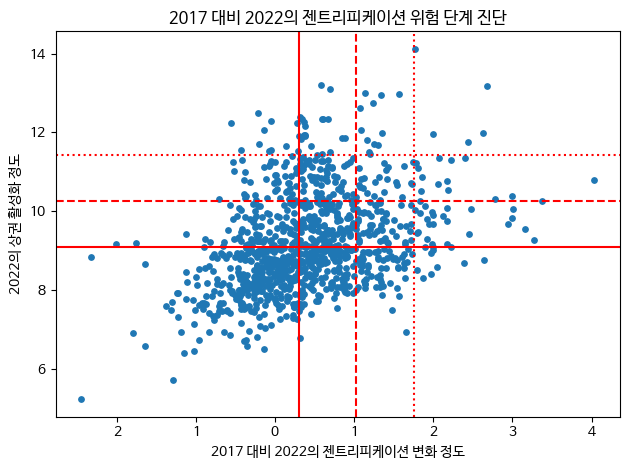

In [12]:
gent_plot(df_mer)

## 2.3) 연도별 조합 데이터 생성

In [ ]:
lst_compare = [(2017, 2018), (2017, 2019), (2017, 2020), (2017, 2021), (2017, 2022),
               (2018, 2019), (2018, 2020), (2018, 2021), (2018, 2022),
               (2019, 2020), (2019, 2021), (2019, 2022),
               (2020, 2021), (2020, 2022),
               (2021, 2022)]
lst_df = []

for past_year, current_year in lst_compare:
    df_mer = gent_process(past_year, current_year)
    lst_df.append(df_mer)


df_con = pd.concat([lst_df[0], lst_df[1]])

for i in range(2, len(lst_df)):
    df_con = pd.concat([df_con, lst_df[i]])

In [153]:
df_con.head()
df_con.shape

,비교년도,현재년도,상권_코드_명,cagr_sum,증가단계구분,lq_sum,현재단계구분,total_sum,x축_1,x축_2,...,LQ_평균_공시지가,실제_음식점_개폐업_점포_수,실제_음식점_프랜차이즈_점포_수,실제_소매점_개폐업_점포_수,실제_소매점_프랜차이즈_점포_수,실제_젊은층_매출_금액,실제_음식점_점포당_평균_매출_금액,실제_소매점_점포당_평균_매출_금액,실제_젊은층_생활인구_수,실제_평균_공시지가
0,2017,2018,4.19민주묘지역 2번,-0.031377,저성장단계,8.388942,도입단계,8.357565,0.088505,0.484131,...,0.459397,3.75,11.00,2.00,2.25,1.204538e+09,2.507455e+07,5.572010e+07,88898.75,1914319.065
1,2017,2018,63빌딩,0.522132,고성장단계,9.988874,성장단계,10.511006,0.088505,0.484131,...,2.115659,4.50,7.75,3.50,1.00,1.605069e+09,7.664215e+07,1.383459e+08,22523.50,8816000.000
2,2017,2018,DMC(디지털미디어시티),-0.136566,저성장단계,10.447610,성숙단계,10.311044,0.088505,0.484131,...,1.484115,65.25,100.25,11.25,24.00,2.191333e+10,5.279973e+07,1.263069e+08,153325.25,6184342.105
3,2017,2018,GS강동자이아파트,-0.228121,저성장단계,7.444437,도입단계,7.216316,0.088505,0.484131,...,0.759337,4.25,8.75,1.75,4.00,1.180153e+09,1.937442e+07,5.906445e+07,257786.00,3164176.000
4,2017,2018,G타워,0.305271,중성장단계,11.279925,완숙단계,11.585196,0.088505,0.484131,...,0.786173,4.50,9.50,2.50,7.00,2.659272e+09,3.034463e+07,7.291565e+07,267941.00,3276000.000


(14828, 43)

In [141]:
# 결과 예시
df_con[df_con['상권_코드_명']=='신용산역(용산역)'].iloc[:, :16]

,비교년도,현재년도,상권_코드_명,cagr_sum,증가단계구분,lq_sum,현재단계구분,total_sum,x축_1,x축_2,x축_3,y축_1,y축_2,y축_3,순위,젠트단계구분
638,2017,2018,신용산역(용산역),0.300750,중성장단계,10.437711,성숙단계,10.738461,0.088505,0.484131,0.879757,8.946976,9.991361,11.035745,11순위,일반단계
638,2017,2019,신용산역(용산역),0.471497,중성장단계,10.564068,성숙단계,11.035565,0.091444,0.574028,1.056613,8.927838,9.970905,11.013972,11순위,일반단계
638,2017,2020,신용산역(용산역),0.503635,중성장단계,11.005268,성숙단계,11.508903,0.298698,0.869848,1.440998,9.104029,10.195958,11.287886,11순위,일반단계
638,2017,2021,신용산역(용산역),0.411962,중성장단계,10.845943,성숙단계,11.257905,0.342357,0.994545,1.646732,9.137975,10.260864,11.383752,11순위,일반단계
638,2017,2022,신용산역(용산역),1.064145,고성장단계,11.100599,성숙단계,12.164744,0.301698,1.026528,1.751358,9.103417,10.260819,11.418221,6순위,위험단계
638,2018,2019,신용산역(용산역),0.177012,중성장단계,10.564068,성숙단계,10.741080,0.056967,0.487448,0.917930,8.927838,9.970905,11.013972,11순위,일반단계
638,2018,2020,신용산역(용산역),0.195418,저성장단계,11.005268,성숙단계,11.200686,0.283711,0.827724,1.371736,9.104029,10.195958,11.287886,11순위,일반단계
638,2018,2021,신용산역(용산역),0.017238,저성장단계,10.845943,성숙단계,10.863181,0.328638,0.946799,1.564960,9.137975,10.260864,11.383752,11순위,일반단계
638,2018,2022,신용산역(용산역),0.717910,중성장단계,11.100599,성숙단계,11.818510,0.264853,0.927146,1.589440,9.103417,10.260819,11.418221,11순위,일반단계
638,2019,2020,신용산역(용산역),-0.075977,저성장단계,11.005268,성숙단계,10.929291,0.253994,0.686006,1.118017,9.104029,10.195958,11.287886,11순위,일반단계


In [155]:
df_con.to_csv('젠트리피케이션_태블로_데이터셋.csv', index=False)